In [1]:
cd /engelhardt/home/jboen/Experiments/GPzoo/

/engelhardt/home/jboen/Experiments/GPzoo


In [2]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
from tqdm.autonotebook import tqdm
from gpzoo.kernels import RBF
from gpzoo.gp import VNNGP, SVGP
from gpzoo.likelihoods import GaussianLikelihood

/tmp/ipykernel_3472154/2282795513.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
import numpy as np
import time
import gc
import pickle as pk


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [68]:
N = 2**10
print(N)
X = distributions.Uniform(-5, 5).sample((N, ))
y = 2*torch.sin(2*X) + distributions.Normal(0.0, 1.0).sample((N,))

1024


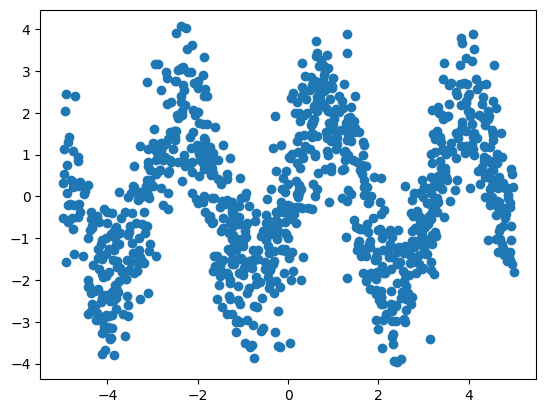

In [69]:
plt.scatter(X, y)

In [79]:
X_train = (X[:, None]).to(device)
y_train = y.to(device)

In [5]:
def fit(model, X, y, optimizer, epochs=1000, E=20, timing = False):
    losses = []

    timings = []
    start_time = time.time()
    
    for it in tqdm(range(epochs)):
        optimizer.zero_grad()
        pY, qF, qU, pU = model.forward(X, E=E)
        ELBO = (pY.log_prob(y)).mean(axis=0).sum()
        ELBO -= torch.sum(distributions.kl_divergence(qU, pU))
        loss = -ELBO
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if timing:
            timings.append(time.time() - start_time)

    print("finished Training")

    if timing:
        return losses, timings
    else:
        return losses

def fit_v2(model, X, y, optimizer, epochs=1000, E=20, timing = False):
    losses = np.zeros(epochs)

    timings = np.zeros(epochs)
    start_time = time.time()
    
    for it in tqdm(range(epochs)):
        optimizer.zero_grad()
        pY, qF, qU, pU = model.forward(X, E=E)
        ELBO = (pY.log_prob(y)).mean(axis=0).sum()
        ELBO -= torch.sum(distributions.kl_divergence(qU, pU))
        loss = -ELBO
        loss.backward()
        optimizer.step()
        
        losses[it] = loss.item()

        if timing:
            timings[it] = time.time() - start_time

    print("finished Training")

    if timing:
        return losses, timings
    else:
        return losses

In [81]:
M = N
kernel = RBF(sigma=1.0, lengthscale=5.0)
gp = VNNGP(kernel, dim=1, M=M, jitter=1e-2)
gp.Z = nn.Parameter(10.0*torch.rand((M, 1))-5.0) #choose inducing points
model = GaussianLikelihood(gp)

model.gp.K = 4

model.to(device)

GaussianLikelihood(
  (gp): VNNGP(
    (kernel): RBF()
  )
)

In [82]:
optimizer = optim.Adam(params= model.parameters(), lr=1e-2)

In [83]:
losses, timings = fit_v2(model, X_train, y_train, optimizer, epochs=1000, E=200, timing = True)

  0%|          | 0/1000 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 23.50 GiB of which 16.62 MiB is free. Process 1732099 has 7.30 GiB memory in use. Process 3216364 has 2.58 GiB memory in use. Process 3249756 has 340.00 MiB memory in use. Process 3457823 has 266.00 MiB memory in use. Including non-PyTorch memory, this process has 12.98 GiB memory in use. Of the allocated memory 12.63 GiB is allocated by PyTorch, and 9.12 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [78]:
with torch.no_grad():
    torch.cuda.empty_cache()

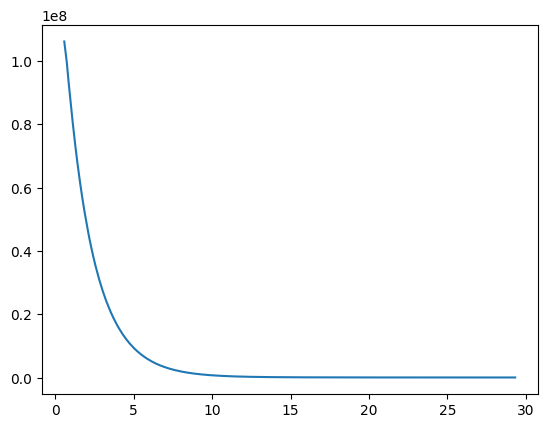

In [12]:
plt.plot(timings, losses)

In [13]:
X_test = torch.linspace(-6, 6, 150)

In [26]:
qF, _, _ = model2.gp(X_test[:, None].to(device), verbose=False)
mean_test = qF.mean.detach().cpu().numpy()
std_test = qF.scale.detach().cpu().numpy()

In [27]:
samples = qF.sample((100,)).detach().cpu().numpy()
samples.shape

(100, 150)

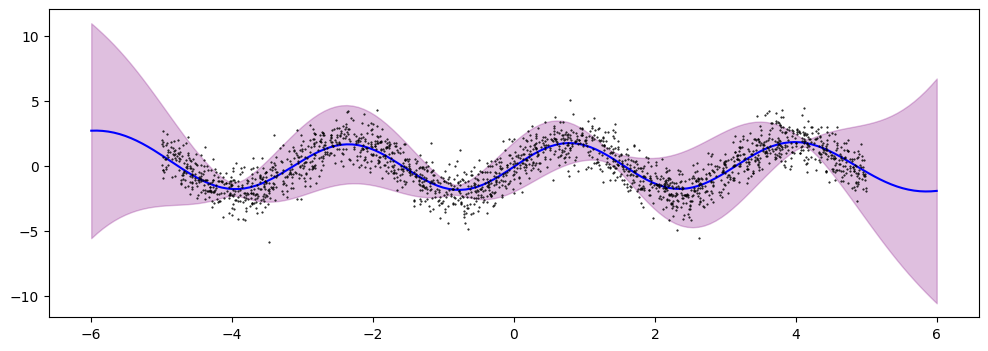

In [28]:
fig, ax = plt.subplots(figsize = (12,4))

ax.plot(X_test, mean_test, 'b-')
#ax.plot(X_test, samples[0,:])
#ax.fill_between(X_test, np.percentile(samples, 25, axis = 0), np.percentile(samples, 75, axis = 0), alpha = 0.25, color = 'blue')
ax.fill_between(X_test, mean_test - std_test, mean_test + std_test, alpha = 0.25, color = 'purple')
ax.plot(X, y, 'ko', markersize = 0.5)

In [ ]:
len(np.arange(100,5000, step = 250))

In [31]:
M = N
kernel = RBF(sigma=1.0, lengthscale=5.0)
gp = SVGP(kernel, dim=1, M=M, jitter=1e-2)
gp.Z = nn.Parameter(10.0*torch.rand((M, 1))-5.0) #choose inducing points
model2 = GaussianLikelihood(gp)

model2.to(device)

GaussianLikelihood(
  (gp): SVGP(
    (kernel): RBF()
  )
)

In [32]:
optimizer = optim.Adam(params= model2.parameters(), lr=1e-2)
losses2, timings2 = fit_v2(model2, X_train, y_train, optimizer, epochs=1000, E=200, timing = True)

  0%|          | 0/1000 [00:00<?, ?it/s]

finished Training


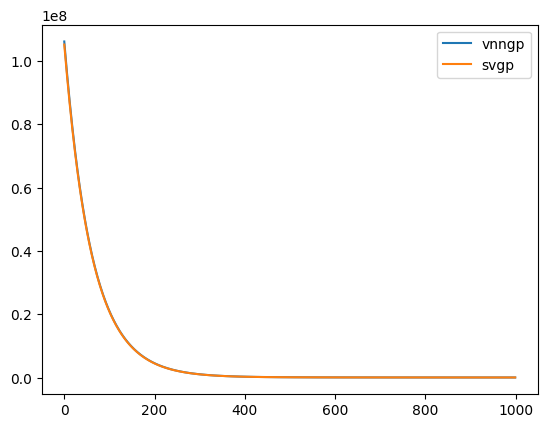

In [25]:
plt.plot(losses, label = 'vnngp')
plt.plot(losses2, label = 'svgp')
plt.legend()

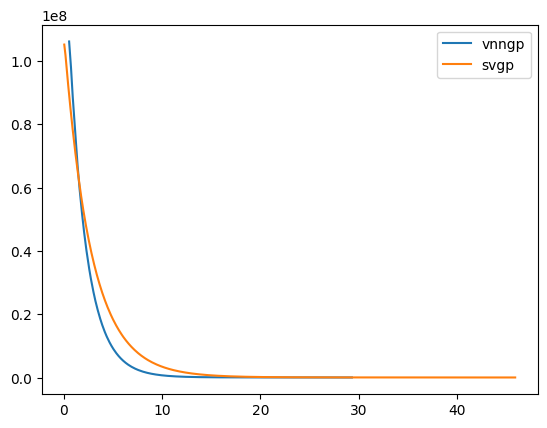

In [19]:
plt.plot(timings, losses, label = 'vnngp')
plt.plot(timings2, losses2, label = 'svgp')
plt.legend()

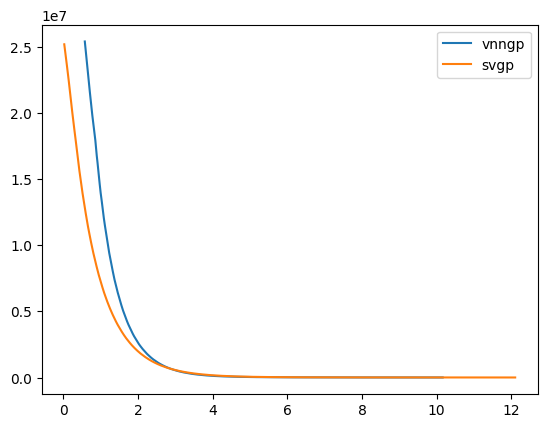

In [20]:
plt.plot(timings, losses, label = 'vnngp')
plt.plot(timings2, losses2, label = 'svgp')
plt.legend()

In [7]:
results_dict = {}

start, end = 8, 12
N_list = np.logspace(start,end, num = (end - start) +1, base = 2).astype(int)

for N in N_list:
    
    X = distributions.Uniform(-5, 5).sample((N, ))
    y = 2*torch.sin(2*X) + distributions.Normal(0.0, 1.0).sample((N,))

    X_train = (X[:, None]).to(device)
    y_train = y.to(device)

    M = N
    kernel = RBF(sigma=1.0, lengthscale=5.0)
    svgp_model = GaussianLikelihood(SVGP(kernel, dim=1, M=M, jitter=1e-2))
    svgp_model.gp.Z = nn.Parameter(10.0*torch.rand((M, 1))-5.0) #choose inducing points
    
    svgp_model.to(device)

    optimizer = optim.Adam(params= svgp_model.parameters(), lr=1e-2)
    loss, duration = fit_v2(svgp_model, X_train, y_train, optimizer, epochs=1000, E=200, timing = True)

    results_dict[N] = {'loss': loss, 'time': duration}

    fp = '/engelhardt/home/jboen/Experiments/models/svgp_model_N={}.pth'.format(N)

    torch.save(svgp_model.state_dict(), fp) 

    with torch.no_grad():
        torch.cuda.empty_cache()

  0%|          | 0/1000 [00:00<?, ?it/s]

finished Training


  0%|          | 0/1000 [00:00<?, ?it/s]

finished Training


  0%|          | 0/1000 [00:00<?, ?it/s]

finished Training


  0%|          | 0/1000 [00:00<?, ?it/s]

finished Training


  0%|          | 0/1000 [00:00<?, ?it/s]

finished Training


In [8]:
fp = '/engelhardt/home/jboen/Experiments/results/svgp_results.pk'
pk.dump(results_dict, open(fp, 'wb'))

In [6]:
results_dict = {}

start, end = 8, 12
N_list = np.logspace(start,end, num = (end - start) +1, base = 2).astype(int)

k = 64

for N in N_list:
    
    X = distributions.Uniform(-5, 5).sample((N, ))
    y = 2*torch.sin(2*X) + distributions.Normal(0.0, 1.0).sample((N,))

    X_train = (X[:, None]).to(device)
    y_train = y.to(device)

    M = N
    kernel = RBF(sigma=1.0, lengthscale=5.0)
    vnngp_model = GaussianLikelihood(VNNGP(kernel, dim=1, M=M, jitter=1e-2))
    vnngp_model.gp.Z = nn.Parameter(10.0*torch.rand((M, 1))-5.0) #choose inducing points
    vnngp_model.gp.K = k
    
    vnngp_model.to(device)

    optimizer = optim.Adam(params=vnngp_model.parameters(), lr=1e-2)
    loss, duration = fit_v2(vnngp_model, X_train, y_train, optimizer, epochs=1000, E=200, timing = True)

    results_dict[N] = {'loss': loss, 'time': duration}

    fp = '/engelhardt/home/jboen/Experiments/models/vnngp_model_N={}_k={}.pth'.format(N,k)

    torch.save(vnngp_model.state_dict(), fp) 

    with torch.no_grad():
        torch.cuda.empty_cache()

fp = '/engelhardt/home/jboen/Experiments/results/vnngp_results_k={}.pk'.format(k)
pk.dump(results_dict, open(fp, 'wb'))

  0%|          | 0/1000 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.00 GiB. GPU 0 has a total capacty of 23.50 GiB of which 3.54 GiB is free. Process 1732099 has 7.30 GiB memory in use. Process 3216364 has 2.58 GiB memory in use. Process 3249756 has 340.00 MiB memory in use. Process 3457823 has 266.00 MiB memory in use. Including non-PyTorch memory, this process has 9.46 GiB memory in use. Of the allocated memory 9.08 GiB is allocated by PyTorch, and 65.46 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [7]:
N_list

array([ 256,  512, 1024, 2048, 4096])